In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [11]:
# Load preprocessed data
# Assuming X_bmkg and y_bmkg are already preprocessed
import numpy as np
X_bmkg = np.load("X_bmkg_cnn_gru.npy")
y_bmkg = np.load("y_bmkg_cnn_gru.npy", allow_pickle=True)

# Verify the shape
print(f"X_bmkg shape: {X_bmkg.shape}")
print(f"y_bmkg shape: {y_bmkg.shape}")

X_bmkg shape: (92878, 10, 10)
y_bmkg shape: (92878,)


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, GRU, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.layers import LeakyReLU

def build_optimized_cnn_gru_model(input_shape):
    model = Sequential()

    # CNN Layers
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))  # LeakyReLU for better gradient flow
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # GRU Layers
    model.add(GRU(units=192, return_sequences=True, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(GRU(units=128, return_sequences=False, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.3))

    # Dense Layers
    model.add(Dense(units=64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='linear'))  # Regression Output

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    return model

In [47]:
# Build the model
input_shape = (10, 10)  # Adjust based on your data
model = build_optimized_cnn_gru_model(input_shape)

In [48]:
from tensorflow.keras.callbacks import LearningRateScheduler
# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Stop if no improvement after 10 epochs
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=5,  # After 5 epochs of no improvement
    min_lr=1e-6  # Minimum learning rate
)
# Define the learning rate scheduler function
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:  # Decay every 5 epochs, excluding the first epoch
        return lr * 0.95  # Multiply the current learning rate by 0.9
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


In [49]:
# Adjust the input shape to match the new data
input_shape = (X_bmkg.shape[1], X_bmkg.shape[2])  # (10, 10)

# Build the model
model = build_optimized_cnn_gru_model(input_shape)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 10, 64)            1984      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 10, 64)            0         
                                                                 
 batch_normalization_13 (Ba  (None, 10, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 5, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 5, 128)            24704     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 5, 128)           

In [50]:
# Train the model
history = model.fit(
    X_bmkg, y_bmkg,
    validation_split=0.2,
    epochs=100,  # Increased to 100 to allow for more learning
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, lr_scheduler],
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
1161/1161 [==============================] - 13s 10ms/step - loss: 1.0422 - mae: 0.7938 - val_loss: 4.9795 - val_mae: 1.8339 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
1161/1161 [==============================] - 11s 9ms/step - loss: 0.8601 - mae: 0.7313 - val_loss: 2.6816 - val_mae: 1.2480 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
1161/1161 [==============================] - 11s 10ms/step - loss: 0.8101 - mae: 0.7111 - val_loss: 0.8677 - val_mae: 0.7159 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
1161/1161 [==============================] - 11s 9ms/step - loss: 0.7572 - mae: 0.6883 - val_loss: 1.5000 - val_mae: 0.8594 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Ep

In [51]:
# report the model performance
loss, mae = model.evaluate(X_bmkg, y_bmkg, verbose=0)
print(f"Training Loss: {loss:.4f}")
print(f"Training MAE: {mae:.4f}")

Training Loss: 0.6030
Training MAE: 0.6163


In [45]:
# Evaluate the model
training_loss, training_mae = model.evaluate(X_bmkg, y_bmkg, verbose=0)
print(f"Training Loss: {training_loss:.4f}")
print(f"Training MAE: {training_mae:.4f}")

Training Loss: 0.5936
Training MAE: 0.6116


In [28]:
# Save the model
model.save('cnn_gru_bmkg_model2.h5')

In [36]:
# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))


<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

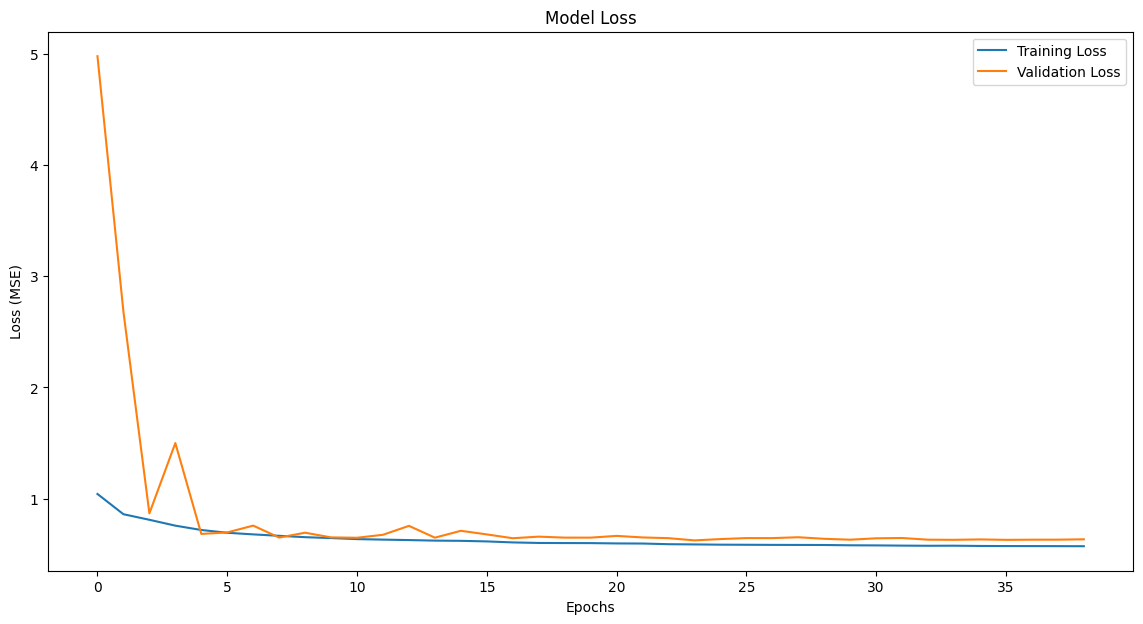

In [53]:
# Plot loss
plt.figure(figsize=(14, 7))
#plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()


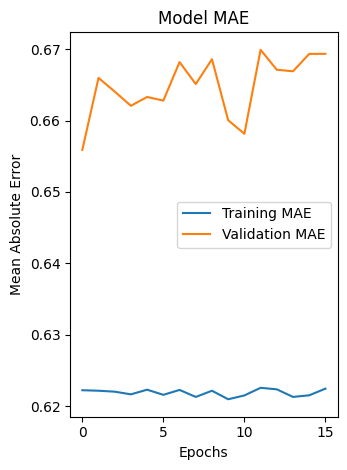

In [38]:
# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


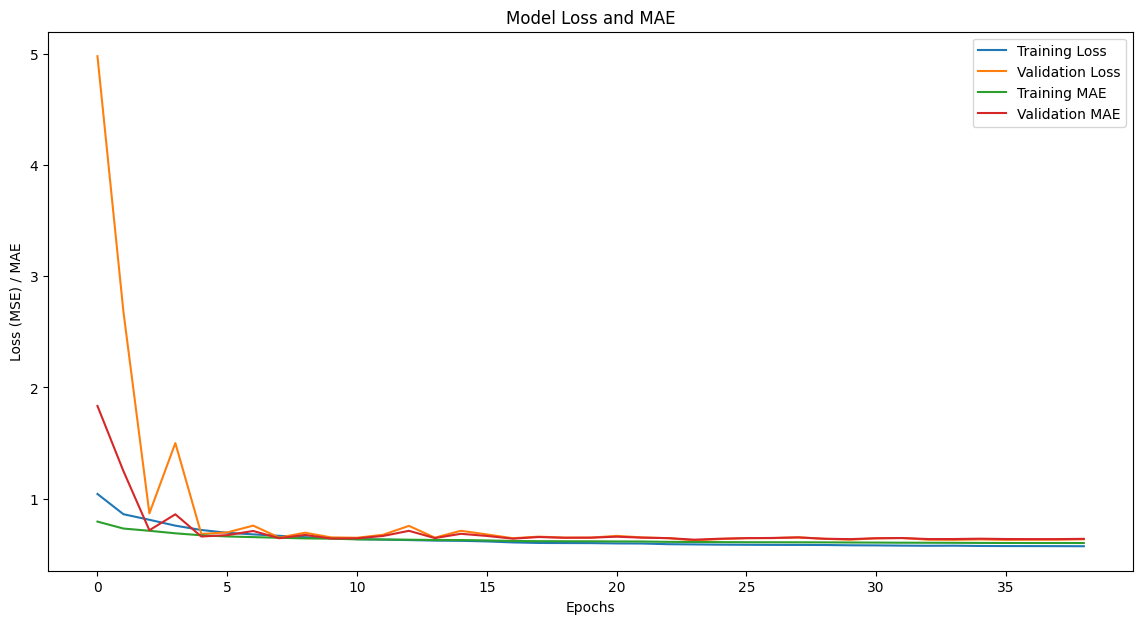

In [54]:
# Plot MAE and Loss together for better comparison
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Loss and MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE) / MAE')
plt.legend()

plt.show()